In [ ]:
import numpy as np

# OBJECTS ##############################################################################################################


class Hopf:
  def __init__(self, config):
    # Load the angles of the path
    self.theta, self.phi = angularPaths1(config)
    self.s2path = angles2path(self.theta, self.phi)
    self.quaternion = angles2quaternion(self.theta, self.phi)
    self.fiber = quaternion2fiber(self.quaternion, config)


def angles2path(theta, phi):

    # path = np.zeros((theta.shape[0], 3, theta.shape[1]))
    theta = theta.reshape(theta.shape[0], 1, theta.shape[1])
    phi = phi.reshape(phi.shape[0], 1, phi.shape[1])

    return np.concatenate((np.sin(theta) * np.cos(phi-np.pi/2),
                           np.sin(theta) * np.sin(phi-np.pi/2),
                           np.cos(theta)),
                          axis=1)


def angles2quaternion(theta, phi):
    # reshape angles
    theta = theta.reshape(1, theta.shape[0], theta.shape[1])
    phi = phi.reshape(1, phi.shape[0], phi.shape[1])
    # quaternion
    q = np.concatenate((np.cos(phi/2)*np.cos(theta/2),
                        -np.sin(phi/2)*np.cos(theta/2),
                        -np.cos(phi/2)*np.sin(theta/2),
                        np.sin(phi/2)*np.sin(theta/2)))
    # convention is that q[0] is positive
    sign_a = np.sign(q[0, :, :])
    sign_a = sign_a.reshape(1, sign_a.shape[0], sign_a.shape[1])
    a_pos = np.concatenate((sign_a, sign_a, sign_a, sign_a))
    q = q * a_pos
    # normalize
    norm = 1 / np.sqrt(q[0, :, :] ** 2 + q[1, :, :] ** 2 + q[2, :, :] ** 2 + q[3, :, :] ** 2)
    norm = norm.reshape(1, norm.shape[0], norm.shape[1])
    norm = np.concatenate((norm, norm, norm, norm))
    # normalize and return
    return q * norm


def quaternion2fiber(q, config):
    # circle exp(i*omega)
    omega = np.linspace(0, 2 * np.pi, config["fiberRes"])
    # outer product of the quaternion and circle (cos and sin)
    qCos = np.swapaxes(np.multiply.outer(q, np.cos(omega)), 2, 3)
    qSin = np.swapaxes(np.multiply.outer(q, np.sin(omega)), 2, 3)
    # initialize
    circleQ = np.zeros(qCos.shape)
    circleQ[0, :, :, :] = qCos[0, :, :, :] + qSin[1, :, :, :]
    circleQ[1, :, :, :] = qCos[1, :, :, :] - qSin[0, :, :, :]
    circleQ[2, :, :, :] = qCos[2, :, :, :] - qSin[3, :, :, :]
    circleQ[3, :, :, :] = qCos[3, :, :, :] + qSin[2, :, :, :]
    # initialize
    f = np.zeros((3, circleQ.shape[1], circleQ.shape[2], circleQ.shape[3]))
    # stereographic projection
    np.seterr(divide='ignore', invalid='ignore')  # suppress divide by 0 warning
    d = 1 / (1 - circleQ[0, :, :, :])
    f[0, :, :, :] = circleQ[1, :, :, :] * d
    f[1, :, :, :] = circleQ[2, :, :, :] * d
    f[2, :, :, :] = circleQ[3, :, :, :] * d
    # fiber list
    f = np.swapaxes(f, 0, 1)
    fiber_list = []
    for idx in range(f.shape[3]):
        fiber_list.append(f[:, :, :, idx])

    return fiber_list


def mag(a, a0=0):
    for idx in range(len(a)):
        a0 = a0 + a[idx] ** 2
    return np.sqrt(a0)


def rodrigues1(aXs, angle):
    if mag(aXs) > 0:
        sinAngle = mag(aXs)
        aXs = aXs / sinAngle
    elif mag(aXs) == 0:
        sinAngle = 0
        angle = 0

    # Lie Algebra Matrices
    LieZ = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 0]])
    LieY = np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]])
    LieX = np.array([[0, 0, 0], [0, 0, -1], [0, 1, 0]])
    # Axis vector as a matrix
    K = LieX * aXs[0] + LieY * aXs[1] + LieZ * aXs[2]

    return np.identity(3) + K * sinAngle + np.matmul(K, K) * (1 - np.cos(angle))


def generateSphere():

    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    return x, y, z

# PATHS ################################################################################################################


# the rotation axis-angle
def aaq(config):
    # path segment length
    seg = int(config["nFrames"] / 16)
    # polar and azimuthal angles
    u = np.concatenate((np.zeros((seg,)),
                        np.linspace(0, (1 / 2) * np.pi, 2 * seg),
                        (1 / 2) * np.pi * np.ones((3 * seg,)),
                        np.linspace((1 / 2) * np.pi, 2 * np.pi, 4 * seg),
                        np.linspace(2 * np.pi, 0, 5 * seg),
                        np.zeros((seg,))))
    v = np.concatenate((np.zeros((seg,)),
                       np.zeros((2 * seg,)),
                       np.linspace(0, (3 / 2) * np.pi, 3 * seg),
                       (3 / 2) * np.pi * np.ones((4 * seg,)),
                        np.linspace(0, 4 * np.pi, 5 * seg),
                        4 * np.pi * np.ones((seg,))))
    # axis
    aXs = []
    aXs.append(np.sin(u) * np.cos(v))
    aXs.append(np.sin(u) * np.sin(v))
    aXs.append(np.cos(u))
    # angle
    ang = np.pi * np.ones((config["nFrames"],)) / 2  # (1 + np.cos(2 * t)) * np.pi
    # return
    return aXs, ang


def angularPaths1(config):
    # tripe torus sequence
    path = definePaths1(config)
    # path = path2
    theta = np.arccos(path[:, 2, :])
    phi = np.mod(np.arctan2(path[:, 1, :], path[:, 0, :]), 2 * np.pi)
    # return polar and azimuthal coordinate of the s2 points
    return theta, phi


def fillCoordinates1(u, v):
    # reshape
    u = u.reshape((u.shape[0], 1, u.shape[1]))
    v = v.reshape((v.shape[0], 1, v.shape[1]))
    # return path in form: [point#, xyz, frame#]
    return np.concatenate((np.cos(u) * np.sin(v), np.cos(u) * np.cos(v), np.sin(u)), axis=1)


def definePaths1(config):

    # groups: up, middle down
    u0 = np.zeros((config["nPoints"], config["nFrames"]))
    u1 = np.ones((config["nPoints"], config["nFrames"]))
    v0 = np.multiply.outer(np.linspace(0, 2 * np.pi, config["nPoints"]),
                           np.ones((config["nFrames"],)))
    v1 = np.multiply.outer(np.ones((config["nPoints"],)),
                           np.linspace(0, config["rotations"] * 2 * np.pi, config["nFrames"]))
    # (u, v) angles
    u = np.concatenate((- u1 * (0.5 * (np.pi / 2)), u0, u1 * (0.5 * (np.pi / 2))))
    v = np.concatenate((v0-v1, v0+v1, v0-v1))
    # fundamental path
    p0 = fillCoordinates1(u, v)
    # axis-angle quaternion
    z, ang = aaq(config)
    p1 = np.zeros(p0.shape)
    r = np.identity(3)
    for idx in range(1, p0.shape[2]):
        a = np.array([z[0][idx], z[1][idx], z[2][idx]])
        b = np.array([z[0][idx-1], z[1][idx-1], z[2][idx-1]])
        # rotation matrix
        aXb = np.cross(a, b)
        ang0 = np.arccos(np.max(np.min((np.dot(a, b), 1)), 0))
        rotor = rodrigues1(aXb, ang0)
        r = np.matmul(r, rotor)
        #
        p1[:, :, idx] = np.matmul(p0[:, :, idx], r)

    return p1

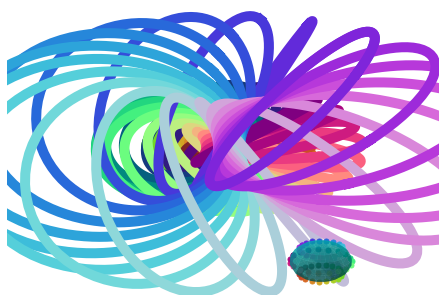

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation



# INITIALIZE FIGURE ####################################################################################################


def genFigure(f, d):
    # # colour range for first frame
    # col = d[:, :, 0] * 0.5 + 0.5
    # generate the 2-sphere for plot animation
    x, y, z = generateSphere()
    # Attaching 3D axis to the figure
    f1 = plt.figure()
    # 3d axes
    ax = p3.Axes3D(f1)
    # ax.axis('equal')
    ax.view_init(30, 30)
    # draw sphere
    ax.plot_surface(0.5 * x + 4, 0.5 * y + 4, 0.5 * z,
                    rstride=1, cstride=1, color='c', alpha=0.6, linewidth=0)
    # initialize the plot
    l1 = [ax.plot(fib[2, :], fib[1, :], fib[0, :],
                  linestyle="-", linewidth=10)[0] for fib in f[0]]                                  # fibers
    p1 = [ax.plot(0.5 * dat[0, 0:1] + 4, 0.5 * dat[1, 0:1] + 4, 0.5 * dat[2, 0:1],
                  linestyle="", marker="o", markersize=5)[0] for dat in d ]                         # points
    # plot parameters
    ax.set_xlim(-2.1, 2.1)
    ax.set_ylim(-2.1, 2.1)
    ax.set_zlim(-2.1, 2.1)
    # Grid off
    plt.axis('off')
    plt.grid(b=None)
    return f1, l1, p1

# UPDATE FIGURE ########################################################################################################


def update_bundle(num, fiberLines, lines, dataPoints, pts):
    for line, fibers, point, data in zip(lines, fiberLines[num], pts, dataPoints):
        # fiber and point colour
        col = data[:, num] * 0.5 + 0.5
        # update the points
        point.set_data(0.5*data[0:2, num]+4)
        point.set_3d_properties(0.5*data[2, num])
        point.set_color(col)
        # update the fibers
        line.set_data(fibers[1:, :])
        line.set_3d_properties(fibers[0, :])
        line.set_color(col)
    return lines + pts

# MAIN SCRIPT ##########################################################################################################


config = {"nPoints": 20,        # number of points per band
          "nFrames": 2 ** 9,    # number of frames in the sequence
          "rotations": 24,      # complete rotations per sequence along central axis
          "fiberRes": 300}      # number of points per fiber line

# FIBER BUNBLES
# h = Hopf(config) returns a Hopf class where:
# h.fiber is a list of config["nFrames"] elements, containing the fibers
# in a array of dimension [config["nPoints"], 3, config["fiberRes"]]
# h.s2path is an array of dimension [config["nPoints"], 3] containing
# the 3d unit sphere coordinates corresponding to each fiber
h = Hopf(config)

# initialize the figure
fig, lines, points = genFigure(h.fiber, h.s2path)

# animate the figure
ani = animation.FuncAnimation(fig,
                              update_bundle,
                              frames=config["nFrames"],
                              fargs=(h.fiber, lines, h.s2path, points),
                              interval=1,
                              blit=True,
                              repeat=False)


# show plot
from IPython.display import HTML
HTML(ani.to_html5_video())